In [1]:
import mplhep as hep, pandas as pd, numpy as np, matplotlib.pyplot as plt
import  collections, argparse, hist, copy, glob, os, re
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from coffea.util import load
from pandas.core.indexes.base import Level
import config

In [15]:
##################################
# Definition of useful functions #
##################################

plot_props = pd.DataFrame(config.plots)

# def get_subdict(dicts, key):
#     '''
#     Get list of subdictionaries(if available) from a list of dictionaries
#     '''
#     out = []
#     for d in dicts:
#         for k in d.keys():
#             if key == k:
#                 out.append(d[key])
#     return out

# def accumulate(dicts):
#     """
#     Merges an array of dictionaries and adds up the values of common keys.

#     Parameters:
#     dicts (list): A list of dictionaries to be merged.

#     Returns:
#     dict: A dictionary with combined keys and values summed for common keys.
#     """
#     exception_list = ['Labels'] # These keys will not be repeated but included once.
#     outdict = {}

#     for diction in dicts:
#         dictionary = copy.deepcopy(diction)

#         for key, value in dictionary.items():
#             # print(f"{key} : {value}")
#             # print(type(value))

#             if isinstance(value,dict):
#                 value = accumulate(get_subdict(dicts,key))
#                 outdict[key] = value
#             else:
#                 if key in outdict.keys():
#                     if key in exception_list:
#                         pass
#                     else:
#                         outdict[key] += value  # Add values if the key is common
#                 else:
#                     outdict[key] = value  # Otherwise, add the new key-value pair
#    return outdict



from collections import defaultdict
from numbers import Number

def accumulate(dicts):
    """
    Recursively merges a list of dictionaries, supporting:
    - Numeric summation
    - List concatenation
    - Set union
    - Histogram addition (from `hist`)
    - Nested dictionaries
    - Key exceptions (preserve first)
    """
    try:
        from hist import Hist
    except ImportError:
        Hist = None  # Skip if hist is not available

    exception_list = {'Labels'}
    grouped = defaultdict(list)

    for d in dicts:
        for k, v in d.items():
            grouped[k].append(v)

    outdict = {}

    for key, values in grouped.items():
        first = values[0]

        if key in exception_list:
            outdict[key] = first
        elif all(isinstance(v, dict) for v in values):
            outdict[key] = accumulate(values)
        elif all(isinstance(v, list) for v in values):
            outdict[key] = sum(values, [])  # concatenate
        elif all(isinstance(v, set) for v in values):
            result = set()
            for v in values:
                result |= v
            outdict[key] = result
        elif Hist and all(isinstance(v, Hist) for v in values):
            total = values[0]
            for v in values[1:]:
                total += v
            outdict[key] = total
        elif all(isinstance(v, Number) for v in values):
            outdict[key] = sum(values)
        else:
            # Mixed types or strings — keep the first
            outdict[key] = first

    return outdict

In [16]:
#########################
# Load the coffea files #
#########################
#Input configuration

input_path = "Batch"+"/"
base_filename = config.output_filename+".coffea"
print(f'Current configuration:\n\tinput_path:\t{input_path}\n\tbase_filename:\t{base_filename}\n')
print("Loading coffea files...")

#Find coffea files
coffea_files = glob.glob(input_path+'*.coffea')
print('Detected coffea files:')
for file in coffea_files : print('\t'+file)
print(f'Choosing:\n\t{base_filename}')

#Find chunked coffea files and combine them
chunked_coffea_files = glob.glob(input_path+base_filename.strip('.coffea')+'-chunk*.coffea')
if len(chunked_coffea_files) != 0 :
    print('Joining chunks:')
    chunk_index_list = []
    chunk_list = []
    for file in chunked_coffea_files:
        print('\t'+file)
        chunk_list.append(file)
        chunk_index_list.append(int(re.search('-chunk(.*).coffea',file).group(1)))
    chunk_index_list.sort()

    #Check if there are missing chunks
    full_set = set(range(len(chunk_index_list)))
    lst_set = set(chunk_index_list)
    missing = list(full_set - lst_set)
    if len(missing) != 0:
        raise FileNotFoundError(f'Missing chunk indexes : {missing}')

    #Load and accumulate all the chunks
    input_list = [load(file) for file in chunk_list]
    input = accumulate(input_list)

#If there is only one chunk no need to join chunks
else :
    input = load(input_path+base_filename)

Current configuration:
	input_path:	Batch/
	base_filename:	4leptons.coffea

Loading coffea files...
Detected coffea files:
	Batch/4leptons-chunk0.coffea
	Batch/4leptons-chunk1.coffea
	Batch/4leptons-chunk10.coffea
	Batch/4leptons-chunk11.coffea
	Batch/4leptons-chunk12.coffea
	Batch/4leptons-chunk13.coffea
	Batch/4leptons-chunk14.coffea
	Batch/4leptons-chunk15.coffea
	Batch/4leptons-chunk16.coffea
	Batch/4leptons-chunk17.coffea
	Batch/4leptons-chunk18.coffea
	Batch/4leptons-chunk19.coffea
	Batch/4leptons-chunk2.coffea
	Batch/4leptons-chunk20.coffea
	Batch/4leptons-chunk21.coffea
	Batch/4leptons-chunk22.coffea
	Batch/4leptons-chunk23.coffea
	Batch/4leptons-chunk24.coffea
	Batch/4leptons-chunk25.coffea
	Batch/4leptons-chunk26.coffea
	Batch/4leptons-chunk27.coffea
	Batch/4leptons-chunk28.coffea
	Batch/4leptons-chunk29.coffea
	Batch/4leptons-chunk3.coffea
	Batch/4leptons-chunk30.coffea
	Batch/4leptons-chunk31.coffea
	Batch/4leptons-chunk4.coffea
	Batch/4leptons-chunk5.coffea
	Batch/4leptons

In [19]:
list(input.keys())

['wzp6_ee_qqH_HZZ_llll_ecm240',
 'wzp6_ee_nunuH_HZZ_ecm240',
 'p8_ee_Zqq_ecm240',
 'p8_ee_WW_ecm240',
 'wzp6_ee_tautauH_HWW_ecm240',
 'wzp6_ee_ccH_HWW_ecm240',
 'wzp6_ee_bbH_HWW_ecm240',
 'wzp6_ee_mumuH_HWW_ecm240',
 'wzp6_ee_mumuH_Hcc_ecm240',
 'wzp6_ee_mumuH_Hbb_ecm240',
 'wzp6_ee_mumuH_Hgg_ecm240',
 'wzp6_ee_mumuH_HZa_ecm240',
 'p8_ee_ZZ_ecm240']

In [90]:
cross_sections = {#in pb # Taken as is from FCC events catalogue at https://fcc-physics-events.web.cern.ch/FCCee/winter2023/Delphesevents_IDEA.php
                  # Signal
                  'wzp6_ee_qqH_HZZ_llll_ecm240':3.777e-5,
                  'wzp6_ee_nunuH_HZZ_ecm240':0.00122,
                  # Backgrounds
                  'p8_ee_Zqq_ecm240':52.6539,
                  'p8_ee_ZZ_ecm240':1.35899,
                  'p8_ee_WW_ecm240':16.4385,
                  'wzp6_ee_tautauH_HWW_ecm240':0.001453,
                  'wzp6_ee_ccH_HWW_ecm240':0.005023,
                  'wzp6_ee_bbH_HWW_ecm240':0.00645,
                  'wzp6_ee_mumuH_HWW_ecm240':0.001456,
                  'wzp6_ee_mumuH_Hcc_ecm240':0.0001956,
                  'wzp6_ee_mumuH_Hbb_ecm240':0.00394,
                  'wzp6_ee_mumuH_Hgg_ecm240':0.0005538,
                  'wzp6_ee_mumuH_HZa_ecm240':1.037e-5,
                  }
intLumi        = 10.80e+06 #in pb-1
# intLumi        = 11.00e+06 #in pb-1

In [91]:
def get_scaled_hist(keys = []):
    out = []
    for key in keys:
        h = input[key]['histograms']['sel0']['Z_non_res_mass']
        raw_mc = input[key]['cutflow']['sel0']['Cutflow'][0]
        scale_factor = intLumi*cross_sections[key] / raw_mc
        out.append(h*scale_factor)
    return sum(out)

In [92]:
ZZ = get_scaled_hist(['p8_ee_ZZ_ecm240'])
Zqq =  get_scaled_hist(['p8_ee_Zqq_ecm240'])
mumuH_Hjj =  get_scaled_hist(['wzp6_ee_mumuH_Hbb_ecm240', 'wzp6_ee_mumuH_Hcc_ecm240', 'wzp6_ee_mumuH_Hgg_ecm240'])
WW = get_scaled_hist(['p8_ee_WW_ecm240'])
HWW = get_scaled_hist(['wzp6_ee_mumuH_HWW_ecm240','wzp6_ee_bbH_HWW_ecm240','wzp6_ee_tautauH_HWW_ecm240','wzp6_ee_ccH_HWW_ecm240'])
mumuH_HZa = get_scaled_hist(['wzp6_ee_mumuH_HZa_ecm240'])

In [93]:
import mplhep as hep
import matplotlib.pyplot as plt

In [97]:
plot_helper = pd.DataFrame({
    'ZZ':{'hist':ZZ, 'label':'ZZ', 'color':'blue'},
    'Zqq':{'hist':Zqq, 'label':'Zqq', 'color':'yellow'},
    'mumuH_Hjj':{'hist':mumuH_Hjj, 'label':'mumuH_Hjj', 'color':'cyan'},
    'WW':{'hist':WW, 'label':'WW', 'color':'gray'},
    'HWW':{'hist':HWW, 'label':'HWW', 'color':'teal'},
    'mumuH_HZa':{'hist':mumuH_HZa, 'label':'mumuH_HZa', 'color':'green'}
})

In [117]:
order = ['ZZ', 'Zqq', 'mumuH_Hjj', 'WW', 'HWW', 'mumuH_HZa']

hists = []
labels = []
colors = []
for o in order[::-1]:
    hists.append(plot_helper[o]['hist'])
    labels.append(plot_helper[o]['label'])
    colors.append(plot_helper[o]['color'])

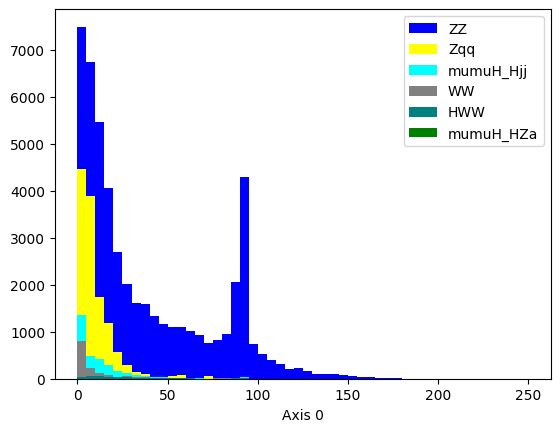

In [118]:
fig, ax = plt.subplots()
hep.histplot(
    hists,
    histtype='fill',
    stack = True,
    label=labels,
    color=colors,
    # sort='label',
    ax = ax
)
# ax.set_yscale('log')
ax.legend();